In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import numba
from numba import jit, njit, prange, int64, cuda
from tqdm import tqdm_notebook as tqdm
import time

In [3]:
from HydroWeno.TimeIntegrate import tvd_rk3, tvd_rk3_cons
from HydroWeno.SimSettings import Prim, Gas, Sim, Cons
from HydroWeno.BCs import reflecting_bc, zero_grad_bc, diode_bc, fixed_bc
from HydroWeno.PrimCons import prim2cons, prim2flux, cons2prim
from HydroWeno.Weno import reconstruct_weno, reconstruct_weno_nm, reconstruct_weno_z, reconstruct_weno_nm_z, reconstruct_weno_log
from HydroWeno.Flux import lax_friedrichs_flux, gforce_flux, lax_friedrichs_flux_cons
from HydroWeno.Simulation import Simulation, Grid, GridCC

In [4]:
def cfl(grid, V):
    cs = np.sqrt(Gas.Gamma * V[Prim.Pres] / V[Prim.Dens])
    vel = cs + np.abs(V[Prim.Velo])
    dt = 0.8 * np.min(grid.dx / vel)
    return dt

# Sod Shock Tube
The simplest, most classic, test case for a 1D hydrodynamic code that may be expected to handle shocks. It has a nice analytic solution too.

In [ ]:
from sodshocktube import sod # analytic solution

In [ ]:
lower_bc = reflecting_bc(position='Lower')
upper_bc = reflecting_bc(position='Upper')
def bcs(grid, V):
    lower_bc(grid, V)
    upper_bc(grid, V)
    
def sod_setup(grid):
    mid = (grid.griBeg + grid.griEnd) // 2
    V = np.zeros((Prim.NumVars, grid.griMax))
    
    V[Prim.Dens, :mid] = 1.0
    V[Prim.Pres, :mid] = 1.0
    V[Prim.Velo] = 0.0
    V[Prim.Dens, mid:] = 0.125
    V[Prim.Pres, mid:] = 0.1
    V[Prim.Eint] = V[Prim.Pres] / ((Gas.Gamma-1.0) * V[Prim.Dens])
    
    bcs(grid, V)
    U = prim2cons(V)
    
    return V, U

def setup(grid):
    mid = (grid.griBeg + grid.griEnd) // 2
    V = np.zeros((Prim.NumVars, grid.griMax))
    
    V[Prim.Dens, :mid] = 1.0
    V[Prim.Pres, :mid] = 1.0
    V[Prim.Velo] = 0.0
    V[Prim.Dens, mid:] = 0.125
    V[Prim.Pres, mid:] = 0.1
    V[Prim.Eint] = V[Prim.Pres] / ((Gas.Gamma-1.0) * V[Prim.Dens])
    
#     mid = int((griBeg + griEnd) * 2/ 5)
#     gr_V[DENS, :mid] = 10.0
#     gr_V[PRES, :mid] = 100.0
#     gr_V[VEL] = 0.0
#     gr_V[DENS, mid:] = 1.0
#     gr_V[PRES, mid:] = 1.0
#     gr_V[EINT] = gr_V[PRES] / ((Gamma-1.0) * gr_V[DENS])
#     gr_V[GAMC] = Gamma
#     gr_V[GAME] = Gamma

#     mid = int((griBeg + griEnd) * 0.1)
#     gr_V[DENS, :mid] = 3.857143
#     gr_V[VEL, :mid] = 2.629369
#     gr_V[PRES, :mid] = 10.3333333
#     gr_V[DENS, mid:] = 1 + 0.2 * np.sin(5 * gridPos[mid:])
#     gr_V[VEL, mid:] = 0.0
#     gr_V[PRES, mid:] = 1.0
#     gr_V[EINT] = gr_V[PRES] / ((Gamma-1.0) * gr_V[DENS])
#     gr_V[GAMC] = Gamma
#     gr_V[GAME] = Gamma

#     gr_V[DENS, :] = 1.0
#     gr_V[VEL, :mid] = -2.0
#     gr_V[VEL, mid:] = 2.0
#     gr_V[EINT, :] = 3.0
#     gr_V[PRES, :] = gr_V[EINT] * (Gamma-1.0) * gr_V[DENS]
#     gr_V[GAMC] = Gamma
#     gr_V[GAME] = Gamma

#     H = 0.5*xEnd # = cs2/|g|
#     cs2 = H * np.abs(Grav)
#     gr_V[PRES, :] = 1e7 * np.exp(-gridPos / H)
#     gr_V[DENS, :] = 1.0 / cs2 * gr_V[PRES, :] 
#     gr_V[VEL, :] = 0.0
#     gr_V[EINT, :] = gr_V[PRES] / ((Gamma-1.0) * gr_V[DENS])
#     gr_V[GAMC] = Gamma
#     gr_V[GAME] = Gamma
    
    bcs(grid, V)
    U = prim2cons(V)
    
    return V, U

Set up computational grid, and Simulation objects. One using a uniform grid, with many points, the other with a non-uniform grid, and fewer points

In [ ]:
interfaces = np.linspace(0, 1, 2001)
grid = Grid(interfaces, 4)

nonUniformInterfaces = np.linspace(0, 1, 301)
dx = nonUniformInterfaces[1] - nonUniformInterfaces[0]
nonUniformInterfaces[1:-1:2] += 0.4 * dx
nonUniformInterfaces[1:-1:3] -= 0.2 * dx
grid_n = Grid(nonUniformInterfaces, 4)

sim = Simulation(grid, sod_setup, bcs, cfl, tvd_rk3, reconstruct_weno, 5, lax_friedrichs_flux)
# sim_nmz = Simulation(grid_n, sod_setup, bcs, cfl, tvd_rk3, reconstruct_weno_log, lax_friedrichs_flux)

In [ ]:
starts = []
ends = []
methods = []
np.seterr(all='raise')
Vinit = np.copy(sim.V)
t=0
tEnd = 0.2
vs = [Vinit]
tq = tqdm(range(10000))
methods.append('WENO 5-Z')
starts.append(time.time())
for i in tq:
    tq.set_description('%f s' % t)
    tMax = tEnd - t
    t += sim.step(tMax)
    vs.append(np.copy(sim.V))
    if t >= tEnd:
        break
ends.append(time.time())
# t = 0
# vs_nmz = [Vinit]
# tq = tqdm(range(10000))
# methods.append('WENO NM-Z Non-Uniform')
# starts.append(time.time())
# for i in tq:
#     tq.set_description('%f s' % t)
#     tMax = tEnd - t
#     t += sim_nmz.step(tMax)
#     vs_nmz.append(np.copy(sim_nmz.V))
#     if t >= tEnd:
#         break
# ends.append(time.time())
print(t)
for i, m in enumerate(methods):
    print('%s: %.3f s' % (m, ends[i] - starts[i]))

In [ ]:
sodPos, sodRegions, sodValues = sod.solve(left_state=(1.0, 1.0, 0.0), right_state=(0.1, 0.125, 0.0), 
                                          geometry=(0.0, 1.0, 0.5), t=0.2, gamma=Gas.Gamma, npts=2001)

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(grid.cc, vs[-1][Prim.Dens], label='Uniform high resolution')
# plt.plot(grid_n.cc, vs_nmz[-1][Prim.Dens], '--', label='Non-uniform low resolution')
plt.plot(sodValues['x'], sodValues['rho'], 'C4--', label='Analytic')
plt.grid()
plt.legend()

The high resolution solution is clearly in very good agreement with the analytic solution. The non-uniform grid, is extremely non-uniform over short lengthscales, and when this method is applied on a uniform grid, it matches the normal WENO5-Z solution. These slight ringing effects are very minor, and shouldn't cause any trouble in the actual simulation, as we should never have a grid where the spacing varies in such a horrible way (print `grid_n.dx` to see quite how bad this is).

In [ ]:
(grid_n.dx / grid_n.dx[0])[4:20] # First 4 cells are ghost cells.

# Overpressure shock wave
This is a very similar problem to the sod shock, just harder to capture, due to the magnitude of the pressure.
The same Riemann solver can be used to find the analytic solution, and some nice animations are shown on [here](http://cococubed.asu.edu/code_pages/ppm_1d.shtml) -- hosted by F. Timmes.

In [ ]:
lower_bc = reflecting_bc(position='Lower')
upper_bc = reflecting_bc(position='Upper')
def bcs(grid, V):
    lower_bc(grid, V)
    upper_bc(grid, V)
    
def overpressure_setup(grid):
    mid = ((grid.griBeg + grid.griEnd) * 2) // 5
    V = np.zeros((Prim.NumVars, grid.griMax))
    
    V[Prim.Dens, :mid] = 10.0
    V[Prim.Pres, :mid] = 100.0
    V[Prim.Velo] = 0.0
    V[Prim.Dens, mid:] = 1.0
    V[Prim.Pres, mid:] = 1.0
    V[Prim.Eint] = V[Prim.Pres] / ((Gas.Gamma-1.0) * V[Prim.Dens])
    
    bcs(grid, V)
    U = prim2cons(V)
    return V, U
    
interfaces = np.linspace(0.0, 5.0, 401)
grid = Grid(interfaces, 4)
nonUniformInterfaces = np.copy(interfaces)
dx = nonUniformInterfaces[1] - nonUniformInterfaces[0]
nonUniformInterfaces[1:-1:2] -= 0.2 * dx
grid_n = Grid(nonUniformInterfaces, 4)
sim = Simulation(grid, overpressure_setup, bcs, cfl, tvd_rk3, reconstruct_weno_z, lax_friedrichs_flux)
sim_n = Simulation(grid_n, overpressure_setup, bcs, cfl, tvd_rk3, reconstruct_weno_nm_z, lax_friedrichs_flux)

In [ ]:
Vinit = np.copy(sim.V)
tEnd = 0.4
t=0
vs = [Vinit]
tq = tqdm(range(10000))
for i in tq:
    tq.set_description('%f s' % t)
    tMax = tEnd - t
    t += sim.step(tMax)
    vs.append(np.copy(sim.V))
    if t >= tEnd:
        break
        
t=0
vs_n = [Vinit]
tq = tqdm(range(10000))
for i in tq:
    tq.set_description('%f s' % t)
    tMax = tEnd - t
    t += sim_n.step(tMax)
    vs_n.append(np.copy(sim_n.V))
    if t >= tEnd:
        break

In [ ]:
overpressurePos, overpressureRegions, overpressureValues = sod.solve(left_state=(100.0, 10.0, 0.0), 
                                                                     right_state=(1.0, 1.0, 0.0), 
                                                                     geometry=(0.0, 5.0, 2.0), 
                                                                     t=0.4, gamma=Gas.Gamma, npts=2001)

In [ ]:
plt.figure()
plt.plot(grid.cc, vs[-1][Prim.Dens])
plt.plot(grid.cc, vs[-1][Prim.Pres] / 10.0)
plt.plot(grid_n.cc, vs_n[-1][Prim.Dens], '--')
plt.plot(grid_n.cc, vs_n[-1][Prim.Pres] / 10.0, '--')
plt.plot(overpressureValues['x'], overpressureValues['rho'], '--')
plt.plot(overpressureValues['x'], overpressureValues['p'] / 10.0, '--')

# Shu-Osher Problem
One of the coolest looking hydrodynamic test cases. This implementation is based on the Athena [test suite](https://www.astro.princeton.edu/~jstone/Athena/tests/shu-osher/Shu-Osher.html).

In [ ]:
lower_bc = zero_grad_bc(position='Lower')
upper_bc = zero_grad_bc(position='Upper')
def bcs(grid, V):
    lower_bc(grid, V)
    upper_bc(grid, V)
    
def shu_osher_setup(grid):
    transition = np.searchsorted(grid.cc, -0.8)
    V = np.zeros((Prim.NumVars, grid.griMax))
    
    V[Prim.Dens, :transition] = 27.0/7.0
    V[Prim.Pres, :transition] = 31.0 / 3.0
    V[Prim.Velo, :transition] = 4.0 * np.sqrt(35.0) / 9.0
    V[Prim.Dens, transition:] = 1.0 + 0.2 * np.sin(5 * np.pi * grid.cc[transition:])
    V[Prim.Pres, transition:] = 1.0
    V[Prim.Velo, transition:] = 0.0
    V[Prim.Eint] = V[Prim.Pres] / ((Gas.Gamma-1.0) * V[Prim.Dens])
#     V[Prim.Eint] = V[Prim.Pres] / ((Gas.Gamma-1.0))
    
    bcs(grid, V)
    U = prim2cons(V)
    return V, U
    
interfaces = np.linspace(-1.0, 1.0, 5001)
grid = Grid(interfaces, 4)
lowRes = np.linspace(-1.0, 1.0, 401)
dx = lowRes[1] - lowRes[0]
lowRes[1:-1:2] -= 0.2 * dx
grid_l = Grid(lowRes, 4)
# nonUniformInterfaces = np.copy(interfaces)
# dx = nonUniformInterfaces[1] - nonUniformInterfaces[0]
# nonUniformInterfaces[1:-1:2] -= 0.2 * dx
# grid_n = Grid(nonUniformInterfaces, 4)
sim = Simulation(grid, shu_osher_setup, bcs, cfl, tvd_rk3, reconstruct_weno_z, lax_friedrichs_flux)
sim_l = Simulation(grid_l, shu_osher_setup, bcs, cfl, tvd_rk3, reconstruct_weno_nm_z, lax_friedrichs_flux)
# sim_n = Simulation(grid_n, overpressure_setup, bcs, cfl, tvd_rk3, reconstruct_weno_nm_z, lax_friedrichs_flux)

In [ ]:
Vinit = np.copy(sim.V)
tEnd = 0.47
t=0
vs = [Vinit]
tq = tqdm(range(10000))
for i in tq:
    tq.set_description('%f s' % t)
    tMax = tEnd - t
    t += sim.step(tMax)
    vs.append(np.copy(sim.V))
    if t >= tEnd:
        break
t=0

Vinit = np.copy(sim_l.V)
vs_l = [Vinit]
tq = tqdm(range(10000))
for i in tq:
    tq.set_description('%f s' % t)
    tMax = tEnd - t
    t += sim_l.step(tMax)
    vs_l.append(np.copy(sim_l.V))
    if t >= tEnd:
        break

In [ ]:
plt.figure()
plt.plot(grid.cc, vs[-1][Prim.Dens])
plt.plot(grid_l.cc, vs_l[-1][Prim.Dens], '--')

# Collela & Woodward Interacting Blast Waves

Also based on the Athena [test suite](https://www.astro.princeton.edu/~jstone/Athena/tests/twoibw/TwoIBW.html).

In [6]:
from functools import reduce
class Validator:
    def __init__(self):
        pass
    
    def validate(self, recon, grid):
        fails = []
        okay = True
        for var in range(Prim.NumVars):
            if var == Prim.Velo:
                continue
            for direction in range(2):
                fails.append(np.argwhere(recon[var, direction, grid.griBeg:grid.griEnd] < 1e-20).squeeze() + grid.griBeg)
        fails = reduce(np.union1d, fails)
        if len(fails) > 0:
            okay = False
            print('YELL:')
            print('  %d fails!!' % len(fails))
            print('  ', fails)
            print('~~~SCREAM~~~')
            
        return okay, fails
        
    def transform(self, prim):
        trans = np.zeros_like(prim)
        for var in range(Prim.NumVars):
            if var == Prim.Velo:
                trans[var] = prim[var]
                continue
            trans[var] = np.log(prim[var])
        return trans
            
    def inverse_transform(self, trans):
        prim = np.zeros_like(trans)
        for var in range(Prim.NumVars):
            if var == Prim.Velo:
                prim[var] = trans[var]
                continue
            prim[var] = np.exp(trans[var])
        return prim
                

In [ ]:
lower_bc = reflecting_bc(position='Lower')
upper_bc = reflecting_bc(position='Upper')
def bcs(grid, V):
    lower_bc(grid, V)
    upper_bc(grid, V)
    
def collela_woodward_setup(grid):
    transition1 = np.searchsorted(grid.cc, 0.1)
    transition2 = np.searchsorted(grid.cc, 0.9)
    V = np.zeros((Prim.NumVars, grid.griMax))
    
    V[Prim.Dens] = 1.0
    V[Prim.Velo] = 0.0
    V[Prim.Pres, :transition1] = 1000.0
    V[Prim.Pres, transition1:transition2] = 0.01
    V[Prim.Pres, transition2:] = 100.0
    V[Prim.Eint] = V[Prim.Pres] / ((Gas.Gamma-1.0) * V[Prim.Dens])
    
    bcs(grid, V)
    U = prim2cons(V)
    return V, U
    
interfaces = np.linspace(0.0, 1.0, 2501)
grid = Grid(interfaces, 4)
# lowRes = np.linspace(0.0, 1.0, 401)
# dx = lowRes[1] - lowRes[0]
# lowRes[1:-1:2] -= 0.2 * dx
# grid_l = Grid(lowRes, 4)
# nonUniformInterfaces = np.copy(interfaces)
# dx = nonUniformInterfaces[1] - nonUniformInterfaces[0]
# nonUniformInterfaces[1:-1:2] -= 0.2 * dx
# grid_n = Grid(nonUniformInterfaces, 4)
sim = Simulation(grid, collela_woodward_setup, bcs, cfl, tvd_rk3, reconstruct_weno, 5, 
                 lax_friedrichs_flux, reconstructionValidator=Validator())
# sim_l = Simulation(grid_l, collela_woodward_setup, bcs, cfl, tvd_rk3, reconstruct_weno_nm_z, lax_friedrichs_flux)
# sim_n = Simulation(grid_n, overpressure_setup, bcs, cfl, tvd_rk3, reconstruct_weno_nm_z, lax_friedrichs_flux)

In [ ]:
np.zeros(0)

In [ ]:
np.seterr(all='raise')
Vinit = np.copy(sim.V)
tEnd = 0.038
t=0
vs = [Vinit]
ts = [0.0]
tq = tqdm(range(10000))
for i in tq:
    tq.set_description('%f s' % t)
    tMax = tEnd - t
    t += sim.step(tMax)
    vs.append(np.copy(sim.V))
    ts.append(t)
    if t >= tEnd:
        break
# t=0

# Vinit = np.copy(sim_l.V)
# vs_l = [Vinit]
# tq = tqdm(range(10000))
# for i in tq:
#     tq.set_description('%f s' % t)
#     tMax = tEnd - t
#     t += sim_l.step(tMax)
#     vs_l.append(np.copy(sim_l.V))
#     if t >= tEnd:
#         break

In [ ]:
plt.figure()
idx = -1
print(ts[idx])
plt.plot(grid.cc, vs[idx][Prim.Dens])
# plt.plot(grid.cc, vs[idx][Prim.Velo])
# plt.plot(grid.cc, vs[idx][Prim.Pres])

# Lax shock tube
As discussed [here](http://doi.org/10.1137/S1064827502412504).

In [ ]:
lower_bc = zero_grad_bc(position='Lower')
upper_bc = zero_grad_bc(position='Upper')
def bcs(grid, V):
    lower_bc(grid, V)
    upper_bc(grid, V)
    
def lax_setup(grid):
    transition = np.searchsorted(grid.cc, 0.0)
    V = np.zeros((Prim.NumVars, grid.griMax))
    
    V[Prim.Dens, :transition] = 0.445
    V[Prim.Velo, :transition] = 0.689
    V[Prim.Pres, :transition] = 3.528
    V[Prim.Dens, transition:] = 0.5
    V[Prim.Velo, transition:] = 0.0
    V[Prim.Pres, transition:] = 0.5710
    
    V[Prim.Eint] = V[Prim.Pres] / ((Gas.Gamma-1.0) * V[Prim.Dens])
#     V[Prim.Eint] = V[Prim.Pres] / ((Gas.Gamma-1.0))
    
    bcs(grid, V)
    U = prim2cons(V)
    return V, U
    
interfaces = np.linspace(-0.5, 0.5, 401)
grid = Grid(interfaces, 4)
# lowRes = np.linspace(-1.0, 1.0, 401)
# dx = lowRes[1] - lowRes[0]
# lowRes[1:-1:2] -= 0.2 * dx
# grid_l = Grid(lowRes, 4)
# nonUniformInterfaces = np.copy(interfaces)
# dx = nonUniformInterfaces[1] - nonUniformInterfaces[0]
# nonUniformInterfaces[1:-1:2] -= 0.2 * dx
# grid_n = Grid(nonUniformInterfaces, 4)
sim = Simulation(grid, lax_setup, bcs, cfl, tvd_rk3, reconstruct_weno, 5, lax_friedrichs_flux)
# sim_l = Simulation(grid_l, shu_osher_setup, bcs, cfl, tvd_rk3, reconstruct_weno_nm_z, lax_friedrichs_flux)
# sim_n = Simulation(grid_n, overpressure_setup, bcs, cfl, tvd_rk3, reconstruct_weno_nm_z, lax_friedrichs_flux)

In [ ]:
Vinit = np.copy(sim.V)
tEnd = 0.16
t=0
vs = [Vinit]
tq = tqdm(range(10000))
for i in tq:
    tq.set_description('%f s' % t)
    tMax = tEnd - t
    t += sim.step(tMax)
    vs.append(np.copy(sim.V))
    if t >= tEnd:
        break

In [ ]:
plt.figure()
plt.plot(grid.cc, vs[-1][Prim.Dens])
plt.plot(grid.cc, vs[-1][Prim.Velo])
plt.plot(grid.cc, vs[-1][Prim.Pres])

# Einfeldt Strong Rarefaction
Once again, refer to the Athena [test cases](https://www.astro.princeton.edu/~jstone/Athena/tests/einfeldt/Einfeldt.html). See [also](https://arxiv.org/pdf/1410.4194.pdf).

In [7]:
lower_bc = zero_grad_bc(position='Lower')
upper_bc = zero_grad_bc(position='Upper')
def bcs(grid, V):
    lower_bc(grid, V)
    upper_bc(grid, V)
    
def einfeldt_setup(grid):
    transition = np.searchsorted(grid.cc, 0.0)
    V = np.zeros((Prim.NumVars, grid.griMax))
    
    V[Prim.Dens, :transition] = 1.0
    V[Prim.Velo, :transition] = -2.0
    V[Prim.Pres, :transition] = 0.4
    V[Prim.Dens, transition:] = 1.0
    V[Prim.Velo, transition:] = 2.0
    V[Prim.Pres, transition:] = 0.4
    
    V[Prim.Eint] = V[Prim.Pres] / ((Gas.Gamma-1.0) * V[Prim.Dens])
#     V[Prim.Eint] = 3.0
#     V[Prim.Pres] = V[Prim.Eint] * ((Gas.Gamma-1.0) * V[Prim.Dens])
#     V[Prim.Eint] = V[Prim.Pres] / ((Gas.Gamma-1.0))
    
    bcs(grid, V)
    U = prim2cons(V)
    return V, U
    
interfaces = np.linspace(-0.5, 0.5, 1001)
grid = Grid(interfaces, 4)
# lowRes = np.linspace(-1.0, 1.0, 401)
# dx = lowRes[1] - lowRes[0]
# lowRes[1:-1:2] -= 0.2 * dx
# grid_l = Grid(lowRes, 4)
# nonUniformInterfaces = np.copy(interfaces)
# dx = nonUniformInterfaces[1] - nonUniformInterfaces[0]
# nonUniformInterfaces[1:-1:2] -= 0.2 * dx
# grid_n = Grid(nonUniformInterfaces, 4)
sim = Simulation(grid, einfeldt_setup, bcs, cfl, tvd_rk3, reconstruct_weno, 5, lax_friedrichs_flux, reconstructionValidator=Validator())
# sim_l = Simulation(grid_l, shu_osher_setup, bcs, cfl, tvd_rk3, reconstruct_weno_nm_z, lax_friedrichs_flux)
# sim_n = Simulation(grid_n, overpressure_setup, bcs, cfl, tvd_rk3, reconstruct_weno_nm_z, lax_friedrichs_flux)

In [8]:
np.seterr(all='raise')
Vinit = np.copy(sim.V)
tEnd = 0.15
t=0
vs = [Vinit]
tq = tqdm(range(10000))
for i in tq:
    tq.set_description('%f s' % t)
    tMax = tEnd - t
    t += sim.step(tMax)
    vs.append(np.copy(sim.V))
    if t >= tEnd:
        break

YELL:
  2 fails!!
   [503 504]
~~~SCREAM~~~


<IPython.core.display.Javascript object>


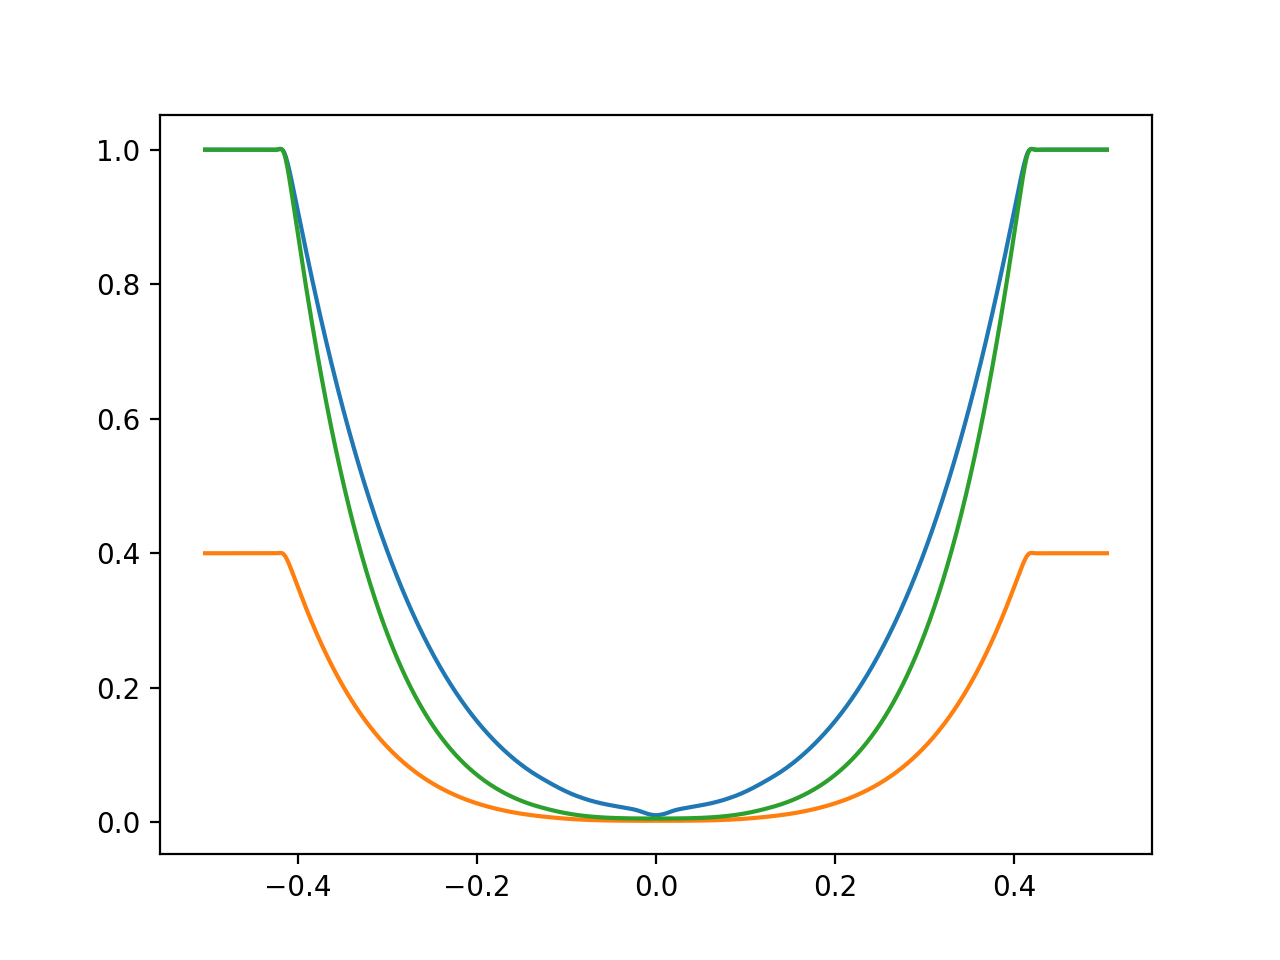

In [9]:
plt.figure()
plt.plot(grid.cc, vs[-1][Prim.Dens])
# plt.plot(grid.cc, vs[-1][Prim.Velo])
plt.plot(grid.cc, vs[-1][Prim.Pres])
plt.plot(grid.cc, vs[-1][Prim.Eint])

In [ ]:
np.any(sim.V[Prim.Pres] < 0.0)